### imports and dependencies

In [ ]:
"""
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip instal sklearn
!pip install matplotlib
!pip install folium
!pip install datetime
"""

In [15]:
#necessary libraries
import pandas as pd
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score



### preperation of data

In [59]:
#loading our datasets
may_data =pd.read_csv(os.path.join("data","may2023.csv"))
april_data =pd.read_csv(os.path.join("data","april2023.csv"))
march_data =pd.read_csv(os.path.join("data","march2023.csv"))

In [60]:
#merging the data for preprocessing
merged_data = pd.concat([march_data,april_data,may_data], axis=0, ignore_index=True)

In [61]:
merged_data.head(3)

,_id,DATE_TIME,LATITUDE,LONGITUDE,GEOHASH,MAXIMUM_SPEED,MINIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,1,2023-03-01 00:00:00,29.284058,41.075134,sxkcdm,109,42,76,116
1,2,2023-03-01 00:00:00,29.097290,40.948792,sxk8yn,82,9,42,27
2,3,2023-03-01 00:00:00,28.493042,41.113586,sxk3bk,93,67,82,6


In [62]:
# Convert the 'datetime' column to a pandas datetime object
merged_data['DATE_TIME'] = pd.to_datetime(merged_data['DATE_TIME'])

# Extract the date and hour from the 'datetime' column
merged_data['date'] = merged_data['DATE_TIME'].dt.date
merged_data['hour'] = merged_data['DATE_TIME'].dt.hour

# Initialize a list to store the results
time_data_list = []

# Iterate through unique date-hour combinations
for date_hour, group in merged_data.groupby(['date', 'hour']):
    date, hour = date_hour
    num_of_vehicles_list = group['NUMBER_OF_VEHICLES'].tolist()
    
    # Calculate the average of num_of_vehicles for the current date-hour combination
    average_num_of_vehicles = sum(num_of_vehicles_list) / len(num_of_vehicles_list)

    # Append the result to the time_data_list
    time_data_list.append({'date-hour': f'{date} {hour:02d}', 'average_num_of_vehicles': average_num_of_vehicles})

# Convert the list of dictionaries to a DataFrame
time_data = pd.DataFrame(time_data_list)

In [63]:
#convert data-type
time_data['date-hour'] = pd.to_datetime(time_data['date-hour'], format='%Y-%m-%d %H')

In [64]:
#checking for null values
time_data.isna().sum()

date-hour                  0
average_num_of_vehicles    0
dtype: int64

In [65]:
time_data.head(3)

,date-hour,average_num_of_vehicles
0,2023-03-01 00:00:00,59.666243
1,2023-03-01 01:00:00,40.381203
2,2023-03-01 02:00:00,28.571938


### Data Vizualization

#### distribution for number of vehicles

In [66]:
#to not confuse the original data with visualization 
time_data_for_viz = time_data.copy()

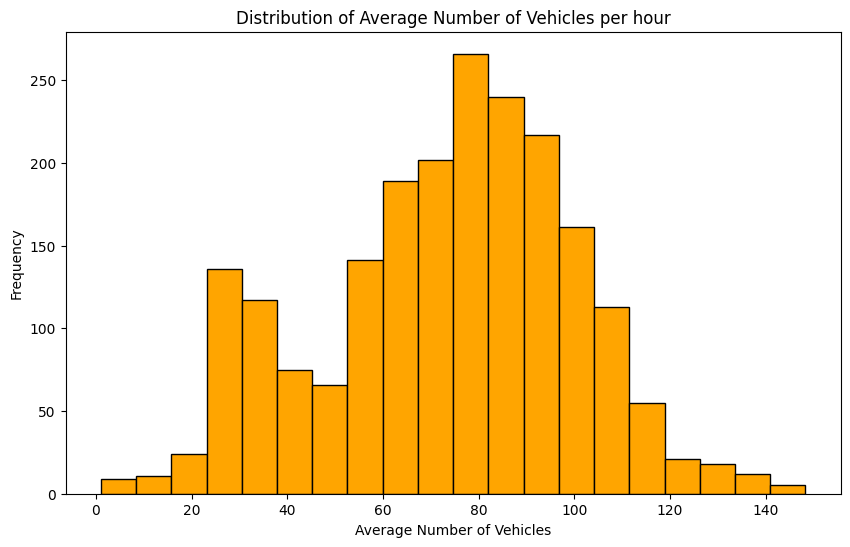

In [67]:
time_data_for_viz.index = pd.to_datetime(time_data_for_viz.index)

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(time_data_for_viz['average_num_of_vehicles'], bins=20, color='orange', edgecolor='black')
plt.xlabel('Average Number of Vehicles')
plt.ylabel('Frequency')
plt.title('Distribution of Average Number of Vehicles per hour')
plt.show()

In [68]:
# Determine the lower and upper bounds for each traffic category
lower_bound = time_data_for_viz['average_num_of_vehicles'].quantile(1/3)
upper_bound = time_data_for_viz['average_num_of_vehicles'].quantile(2/3)

# Create a new column 'traffic_category' based on the bounds
time_data_for_viz['traffic_category'] = pd.cut(time_data_for_viz['average_num_of_vehicles'],
                                bins=[-float('inf'), lower_bound, upper_bound, float('inf')],
                                labels=['less traffic', 'medium traffic', 'busy traffic'])

In [69]:
# Print the bounds
print(f'Lower Bound (less traffic): {lower_bound}')
print(f'Upper Bound (busy traffic): {upper_bound}')

Lower Bound (less traffic): 65.03021698546533
Upper Bound (busy traffic): 86.84494226769269


In [37]:
#meaning that 
#   .-65 cars - less traffic
#   65-86 cars - medium traffic
#   86-. cars -  busy traffic

In [70]:
time_data_for_viz.head(2)

,date-hour,average_num_of_vehicles,traffic_category
1970-01-01 00:00:00.000000000,2023-03-01 00:00:00,59.666243,less traffic
1970-01-01 00:00:00.000000001,2023-03-01 01:00:00,40.381203,less traffic


#### number of vehicles for each hour

In [71]:
#to not confuse the original data with visualization 
time_data_for_viz2 = time_data.copy()

In [72]:
# Assuming time_data is your DataFrame with a datetime column "date-hour" and 'average_num_of_vehicles' column
time_data_for_viz2['date-hour'] = pd.to_datetime(time_data_for_viz2['date-hour'])

# Extract hour information from the datetime column
time_data_for_viz2['hour'] = time_data_for_viz2['date-hour'].dt.hour

# Calculating the mean number of vehicles for each hour
mean_per_hour = time_data_for_viz2.groupby('hour')['average_num_of_vehicles'].mean()

# Create a DataFrame with 24 rows representing 24 hours and their mean values
subset_df_for_hours = pd.DataFrame({'hour': range(24), 'mean_num_of_vehicles': mean_per_hour})

In [73]:
# to make dataset prettier let's rearrange it
from datetime import time
subset_df_for_hours= subset_df_for_hours.reset_index(drop=True)
# Convert the 'hour' index to datetime.time
subset_df_for_hours.index = [time(hour=x) for x in subset_df_for_hours.index]

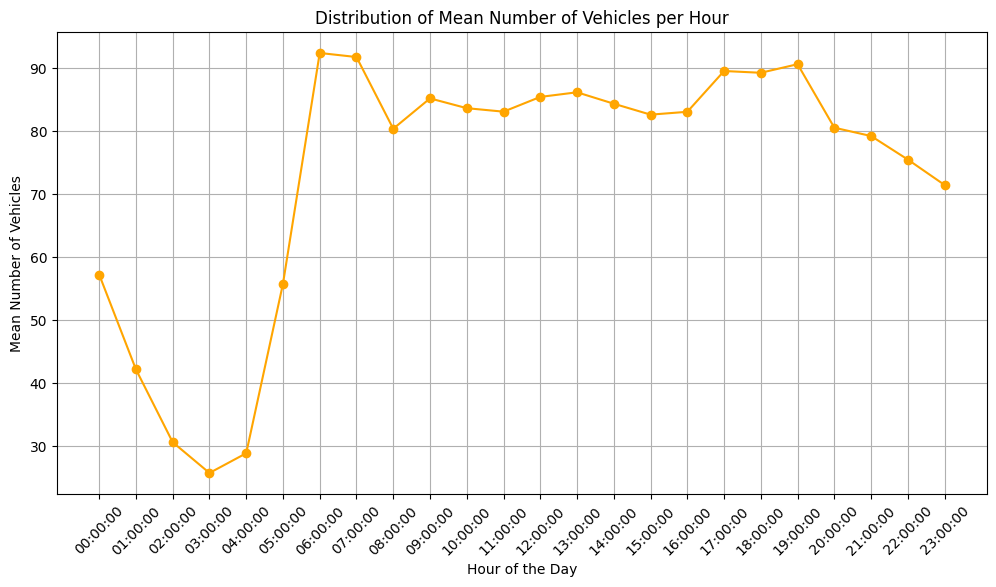

In [74]:
# Convert datetime.time objects to strings for plotting
subset_df_for_hours['hour_str'] = subset_df_for_hours.index.astype(str)
# Plotting with Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(subset_df_for_hours['hour_str'], subset_df_for_hours['mean_num_of_vehicles'], marker='o', color='orange', linestyle='-')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Number of Vehicles')
plt.title('Distribution of Mean Number of Vehicles per Hour')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [75]:
subset_df_for_hours['traffic_category'] = pd.cut(subset_df_for_hours['mean_num_of_vehicles'],
                                       bins=[-float('inf'), 65, 86, float('inf')],
                                       labels=['less traffic', 'medium traffic', 'busy traffic'])

# Set a color palette for the traffic categories
traffic_palette = {'less traffic': 'green', 'medium traffic': 'yellow', 'busy traffic': 'red'}

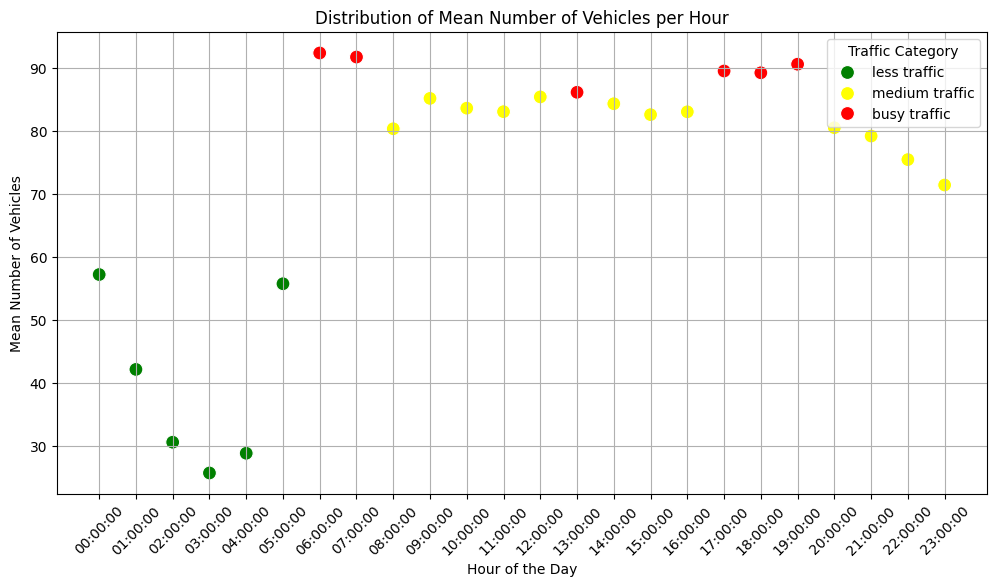

In [76]:
import seaborn as sns
# Plotting with Seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x=subset_df_for_hours['hour_str'], y='mean_num_of_vehicles', hue='traffic_category', data=subset_df_for_hours,
                palette=traffic_palette, s=100, legend='full')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Number of Vehicles')
plt.title('Distribution of Mean Number of Vehicles per Hour')
plt.xticks(rotation=45)
plt.legend(title='Traffic Category')
plt.grid(True)

# Display the plot
plt.show()

#### hourly speed range

In [78]:
merged_data['DATE_TIME'] = pd.to_datetime(merged_data['DATE_TIME'])
# Extract the hour and date from the datetime column
merged_data['hour'] = merged_data['DATE_TIME'].dt.hour
merged_data['date'] = merged_data['DATE_TIME'].dt.date

# Group by date and hour, calculate the mean for selected columns
mean_per_hour = merged_data.groupby(['date', 'hour']).agg({
    'MINIMUM_SPEED': 'mean',
    'MAXIMUM_SPEED': 'mean',
    'AVERAGE_SPEED': 'mean'
}).reset_index()

In [79]:
#now let's get the means of each hour
mean_per_hour_all_dates = mean_per_hour.groupby('hour').agg({
    'MINIMUM_SPEED': 'mean',
    'MAXIMUM_SPEED': 'mean',
    'AVERAGE_SPEED': 'mean'
}).reset_index()

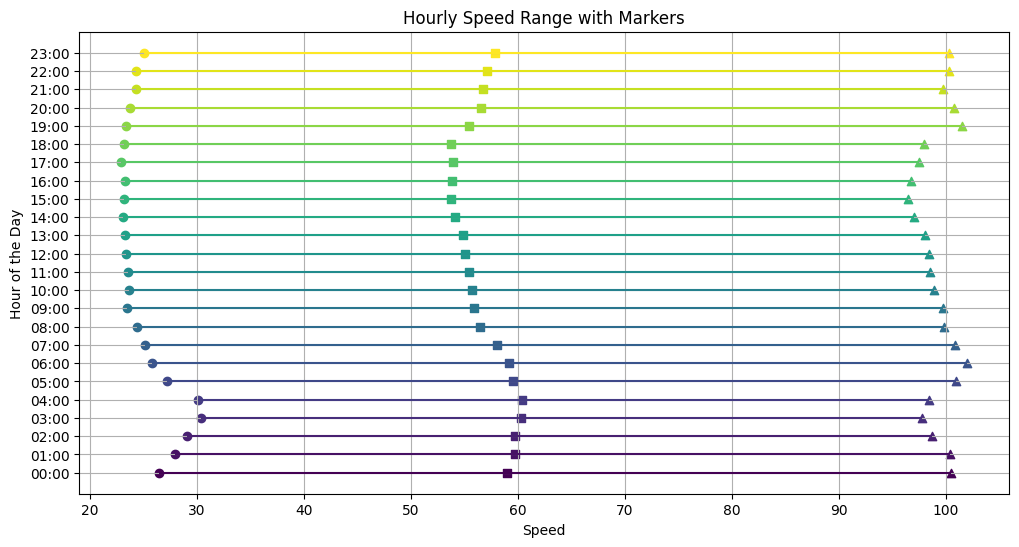

In [80]:
from datetime import datetime

# Assuming your DataFrame is named mean_per_hour_all_dates
# Convert numeric hour to real hour format with leading zeros
mean_per_hour_all_dates['hour_str'] = mean_per_hour_all_dates['hour'].apply(lambda x: datetime.strptime(str(x), "%H").strftime("%H:%M"))

# Plotting with Matplotlib
plt.figure(figsize=(12, 6))

# Generate a color map for lines
colors = plt.cm.viridis(np.linspace(0, 1, len(mean_per_hour_all_dates)))

# Plot horizontal lines for each row (hour) representing the range from minimum to maximum speed
for index, (color, row) in enumerate(zip(colors, mean_per_hour_all_dates.iterrows())):
    plt.hlines(y=row[1]['hour_str'], xmin=row[1]['MINIMUM_SPEED'], xmax=row[1]['MAXIMUM_SPEED'], color=color, linestyle='-')
    
    # Add markers for minimum, maximum, and average speed values
    plt.scatter(row[1]['MINIMUM_SPEED'], row[1]['hour_str'], color=color, marker='o')
    plt.scatter(row[1]['MAXIMUM_SPEED'], row[1]['hour_str'], color=color, marker='^')
    plt.scatter(row[1]['AVERAGE_SPEED'], row[1]['hour_str'], color=color, marker='s')

# Add labels and title
plt.ylabel('Hour of the Day')
plt.xlabel('Speed')
plt.title('Hourly Speed Range with Markers')
plt.grid(True)

# Display the plot
plt.show()

#### mean number of vehicles per month

In [86]:
#to not confuse the original data with visualization 
time_data_for_viz3 = time_data.copy()

In [89]:
time_data_for_viz3

,date-hour,average_num_of_vehicles
0,2023-03-01 00:00:00,59.666243
1,2023-03-01 01:00:00,40.381203
2,2023-03-01 02:00:00,28.571938
3,2023-03-01 03:00:00,25.007168
4,2023-03-01 04:00:00,30.330247
...,...,...
2073,2023-05-31 19:00:00,99.721943
2074,2023-05-31 20:00:00,85.709933
2075,2023-05-31 21:00:00,79.753258
2076,2023-05-31 22:00:00,65.561840


In [93]:
# Assuming time_data_for_viz3 is your DataFrame with a datetime column "date-hour" and 'average_num_of_vehicles' column
time_data_for_viz3['date-hour'] = pd.to_datetime(time_data_for_viz3['date-hour'])

# Calculating the average number of vehicles per day
mean_avg_vehicles_per_day = time_data_for_viz3.groupby(time_data_for_viz3['date-hour'].dt.date)['average_num_of_vehicles'].mean()

# Convert the result to a DataFrame
result_df = mean_avg_vehicles_per_day.reset_index()

# Organizing the data for mean number of vehicles per month
result_df['date-hour'] = pd.to_datetime(result_df['date-hour'])
mean_per_month = result_df.groupby(result_df['date-hour'].dt.month)['average_num_of_vehicles'].mean()

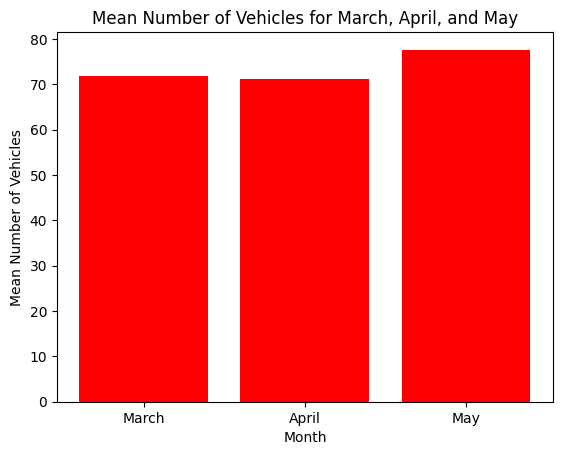

In [94]:
# Create a mapping of month numbers to month names
month_mapping = {3: 'March', 4: 'April', 5: 'May'}

# Map the month numbers to month names for the x-axis tick labels
month_labels = [month_mapping[month] for month in mean_per_month.index]

# Plot the mean number of vehicles for each month
plt.bar(month_labels, mean_per_month.values,color="red")
plt.xlabel('Month')
plt.ylabel('Mean Number of Vehicles')
plt.title('Mean Number of Vehicles for March, April, and May')
plt.show()

#### Map

In [95]:
from geopy.geocoders import ArcGIS
import folium
nom= ArcGIS()

In [96]:
city_map=nom.geocode("İstanbul")
city_map.latitude,city_map.longitude

(41.06201, 28.98877)

In [97]:
city_map=folium.Map(location=[41.06201, 28.98877])

In [98]:
# Convert 'DATE_TIME' to datetime format
merged_data['DATE_TIME'] = pd.to_datetime(merged_data['DATE_TIME'])

# Extract date and hour from 'DATE_TIME'
merged_data['DATE'] = merged_data['DATE_TIME'].dt.strftime('%Y-%m-%d')
merged_data['HOUR'] = merged_data['DATE_TIME'].dt.hour

# Calculate hourly mean number of vehicles for each unique location
hourly_mean_vehicles = merged_data.groupby(['DATE', 'HOUR', 'LATITUDE', 'LONGITUDE'], as_index=False)['NUMBER_OF_VEHICLES'].mean()

In [99]:
hourly_mean_vehicles.head(2)

,DATE,HOUR,LATITUDE,LONGITUDE,NUMBER_OF_VEHICLES
0,2023-03-01,0,27.965698,40.981750,9.0
1,2023-03-01,0,27.965698,40.987244,17.0


In [100]:
# Assuming you want a subset for date '2023-03-01' and hour 0
subset_date_hour = hourly_mean_vehicles[(hourly_mean_vehicles['DATE'] == '2023-03-01') & (hourly_mean_vehicles['HOUR'] == 0)]

In [101]:
entry = []

for index, row in subset_date_hour.iterrows():
    latitude = row['LATITUDE']
    longitude = row['LONGITUDE']
    vehicles = row['NUMBER_OF_VEHICLES']
    
    entry.append([latitude, longitude, vehicles])

In [ ]:
city_map = folium.Map(location=[41.06201, 28.98877])
fg = folium.FeatureGroup(name="flow")

for i in entry:
    popup_value = i[2]
    
    # Determine the color based on the popup value
    if popup_value < 65:
        color = "green"
    elif 65 <= popup_value <= 86:
        color = "orange"
    else:
        color = "red"

    fg.add_child(folium.Marker(location=[i[1], i[0]], popup=str(popup_value), icon=folium.Icon(color=color)))

city_map.add_child(fg)
folium.LayerControl().add_to(city_map)

# Display the map
city_map

In [103]:
#city_map.save("flow_on_01.03.2023-00.00.html")

In [104]:
import folium
city_map = folium.Map(location=[41.06201, 28.98877], zoom_start=12)
fg = folium.FeatureGroup(name="flow")

for i in entry:
    popup_value = i[2]
    
    # Determine the color based on the popup value
    if popup_value < 65:
        color = "green"
    elif 65 <= popup_value <= 86:
        color = "orange"
    else:
        color = "red"

    # Add scatter plots instead of markers
    fg.add_child(folium.CircleMarker(location=[i[1], i[0]], radius=5, popup=str(popup_value), color=color, fill=True, fill_color=color))

city_map.add_child(fg)
folium.LayerControl().add_to(city_map)

In [ ]:
city_map

In [106]:
#city_map.save("flow_on_01.03.2023-00.00_circles.html")

### Modeling



Epoch 1/40

83/83 [==============================] - 7s 23ms/step - loss: 0.0642 - val_loss: 0.0319
Epoch 2/40
83/83 [==============================] - 1s 13ms/step - loss: 0.0294 - val_loss: 0.0283
Epoch 3/40
83/83 [==============================] - 1s 13ms/step - loss: 0.0261 - val_loss: 0.0255
Epoch 4/40
83/83 [==============================] - 1s 13ms/step - loss: 0.0236 - val_loss: 0.0246
Epoch 5/40
83/83 [==============================] - 1s 13ms/step - loss: 0.0218 - val_loss: 0.0190
Epoch 6/40
83/83 [==============================] - 1s 16ms/step - loss: 0.0180 - val_loss: 0.0138
Epoch 7/40
83/83 [==============================] - 1s 13ms/step - loss: 0.0149 - val_loss: 0.0129
Epoch 8/40
83/83 [==============================] - 1s 13ms/step - loss: 0.0139 - val_loss: 0.0120
Epoch 9/40
83/83 [==============================] - 1s 13ms/step - loss: 0.0149 - val_loss: 0.0108
Epoch 10/40
83/83 [==============================] - 1s 13ms/step - loss: 0.0129 - val_loss: 0.0108
Epoch 

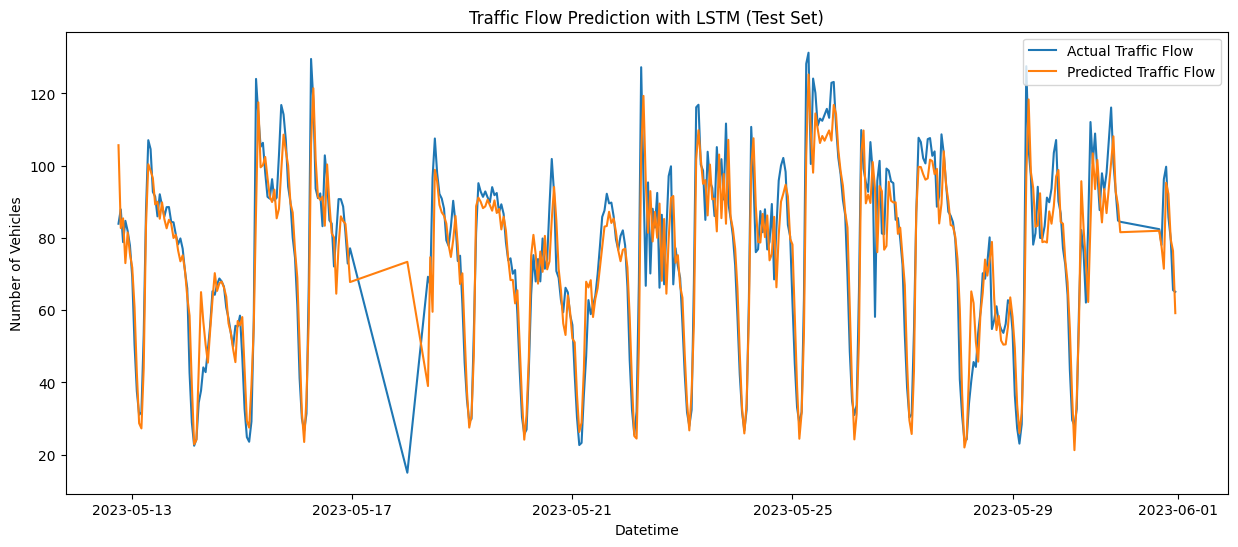

In [108]:
# Convert 'date-hour' to datetime and set it as the index
time_data['date-hour'] = pd.to_datetime(time_data['date-hour'])
time_data.set_index('date-hour', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_data)

# Create sequences for the LSTM model
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps, 0])  # Assuming 'average_num_of_vehicles' is at index 0
    return np.array(X), np.array(y)

n_steps = 10
X, y = create_sequences(scaled_data, n_steps)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=16, validation_split=0.2)

# Make predictions on the test set
test_predict = model.predict(X_test)

# Inverse transform the predictions to get the actual values
test_predict = scaler.inverse_transform(np.hstack([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))]))

# Plot the predictions against the actual values for the test set
plt.figure(figsize=(15, 6))
plt.plot(time_data.index[train_size + n_steps:], scaler.inverse_transform(scaled_data)[train_size + n_steps:], label='Actual Traffic Flow')
plt.plot(time_data.index[train_size + n_steps:], test_predict, label='Predicted Traffic Flow')
plt.title('Traffic Flow Prediction with LSTM (Test Set)')
plt.xlabel('Datetime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

In [109]:
# Inverse transform the actual values for the test set
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate additional evaluation metrics
mae = mean_absolute_error(actual_values, test_predict)
r2 = r2_score(actual_values, test_predict)

# Print the evaluation metrics
print("Mean Absolute Error:", mae)
print("R-squared (R2) Score:", r2)

Mean Absolute Error: 7.4765202543723435
R-squared (R2) Score: 0.8355569378093801
